In [25]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from util.pca import perform_pca
from util.k_folds_cross_val import k_folds_x_val, get_cmat, get_metrics
from util.hpo import gridSearchHPO
from util.forward_select import forward_select, forward_select_and_fit

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import sklearn as skl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Loading

In [26]:
NUM_CLASSES = 6
CLASSES = ["sadnesss", "joy", "love", "anger", "fear"]

# Load all data
train_data = pd.read_csv("../data/training_labse.csv")
test_data = pd.read_csv("../data/test_labse.csv")
validation_data = pd.read_csv("../data/validation_labse.csv")

# Separate X's and y's from each other
FEATURE_COLUMNS = [x for x in train_data if x.startswith("_e")]
LABEL_COLUMN = "label"

In [27]:
X_train = train_data[FEATURE_COLUMNS]
Y_train = train_data[LABEL_COLUMN]

X_test = test_data[FEATURE_COLUMNS]
Y_test = test_data[LABEL_COLUMN]

X_val = validation_data[FEATURE_COLUMNS]
Y_val = validation_data[LABEL_COLUMN]

# These are used to run cross validation
X_train_val = pd.concat([X_train, X_val]) 
Y_train_val = pd.concat([Y_train, Y_test])

# These are used to run val and test for Neural Nets
X_val_test = pd.concat([X_val, X_test])
Y_val_test = pd.concat([Y_val, Y_test])

In [28]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

In [29]:
X_train_used = X_train_unreduced
X_val_used = X_val_unreduced
X_test_used = X_test_unreduced
X_train_val_used = X_train_val_unreduced 
X_val_test_used = X_val_test_unreduced

# Principal Component Analysis (PCA)

In [30]:
TARGET_EXPLAINED_VARIANCE = 0.95

pca_train, X_train_reduced = perform_pca(X_train, TARGET_EXPLAINED_VARIANCE)
X_val_reduced = pca_train.transform(X_val)
X_test_reduced = pca_train.transform(X_test)
X_train_val_reduced = pca_train.transform(X_train_val)
X_val_test_reduced = pca_train.transform(X_val_test)

print(f"{pca_train.n_components_} components for training")

180 components for training


In [31]:
X_train_unreduced = X_train.to_numpy()
X_val_unreduced = X_val.to_numpy()
X_test_unreduced = X_test.to_numpy()
X_train_val_unreduced = X_train_val.to_numpy()
X_val_test_unreduced = X_val_test.to_numpy()

In [32]:
X_train_used = X_train_reduced
X_val_used = X_val_reduced
X_test_used = X_test_reduced
X_train_val_used = X_train_reduced 
X_val_test_used = X_val_reduced

# K Nearest Neighbors

In [33]:
k_nearest_model = KNeighborsClassifier(
    n_jobs=2,
    weights="uniform",
    algorithm="ball_tree",
    metric="cityblock",
    leaf_size=2,
    n_neighbors=60
)

# Grid Search Hyperparameter Optimization

In [34]:
knn_search_space = {
    "n_neighbors": [30],
    # "weights": ['uniform', 'distance'], # Uniform
    # "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'], # ball tree
    # "metric": ['cityblock', 'euclidean', 'l1', 'l2', 'manhattan', 'minkowski'], # city block
    # "leaf_size": [2], # 2
}

model_knn = k_nearest_model.fit(X_train_used, Y_train)

gridsearch_knn = gridSearchHPO(model=model_knn, search_space=knn_search_space)

In [35]:
gridsearch_knn.fit(X_train_used, Y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5, error_score='raise',
             estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=2,
                                            metric='cityblock', n_jobs=2,
                                            n_neighbors=60),
             n_jobs=-1, param_grid={'n_neighbors': [30]}, scoring='accuracy',
             verbose=3)

In [36]:
print("Best Score: {}".format(gridsearch_knn.best_score_))
print("Best params: {}".format(gridsearch_knn.best_params_))

Best Score: 0.5375
Best params: {'n_neighbors': 30}


(0.165, 0.09006567216632137)


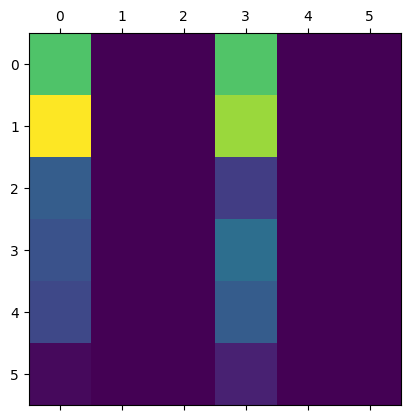

In [37]:
cmat = get_cmat(gridsearch_knn, X_test_used, Y_test)
print(get_metrics(gridsearch_knn, X_test_used, Y_test))
plt.matshow(cmat)
plt.show()